✅ Data Loaded Successfully

HYPOTHESIS 1: The 'Fast Food' Effect
H0: Mean obesity rate is equal for High vs. Low Fast Food countries.
H1: Mean obesity rate is higher for High Fast Food countries.

Data Split (Median Threshold: 4.69%):
 - High Fast Food Group: n=10 (Mean Obesity: 26.9%)
 - Low Fast Food Group:  n=9 (Mean Obesity: 23.8%)

Assumption Checks:
 - Normality (High Group): p=0.016 (Violated)
 - Normality (Low Group):  p=0.189 (Met)
 - Equal Variances:        p=0.930 (Met)

-> Using Mann-Whitney U Test (due to normality violation)

>>> TEST RESULT: REJECT H0
    Mann-Whitney U Statistic: 75.000
    p-value: 0.0078


C:\Users\sivam\AppData\Local\Temp\ipykernel_40696\2796521657.py:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Group', y='obesity_rate', data=ff_data, palette='Set2')


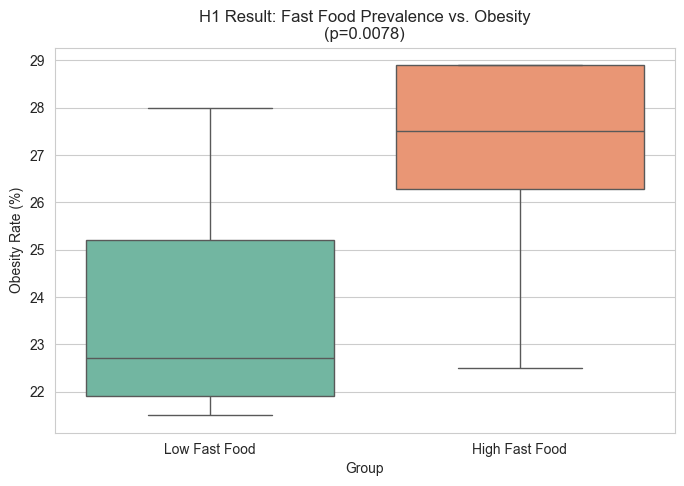


HYPOTHESIS 2: The 'Healthy Label' Paradox
H0: No correlation between 'Healthy' restaurant % and obesity.
H1: Negative correlation (More healthy food = Less obesity).

>>> TEST RESULT: FAIL TO REJECT H0
    Pearson Correlation (r): -0.005
    p-value: 0.9824
    -> Conclusion: The label 'Healthy' on TripAdvisor is NOT associated with lower national obesity.


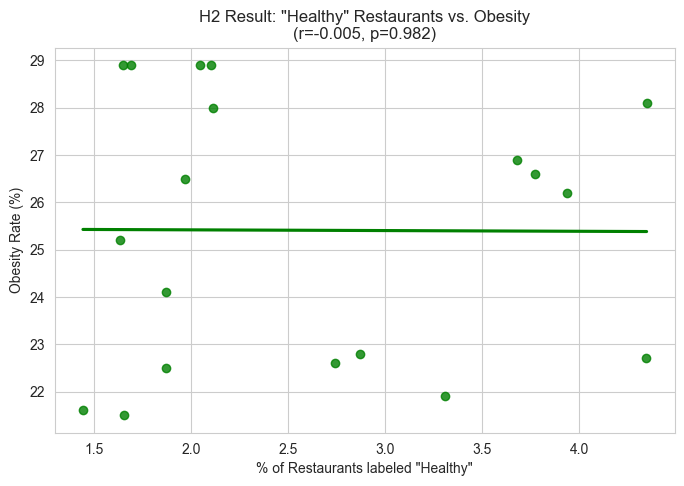


HYPOTHESIS 3: Economic Confounding (GDP Control)
H0: Fast Food % does not predict obesity when controlling for GDP.
H1: Fast Food % remains a significant predictor.

>>> REGRESSION SUMMARY:
                            OLS Regression Results                            
Dep. Variable:           obesity_rate   R-squared:                       0.648
Model:                            OLS   Adj. R-squared:                  0.604
Method:                 Least Squares   F-statistic:                     14.73
Date:                Sat, 29 Nov 2025   Prob (F-statistic):           0.000235
Time:                        16:17:25   Log-Likelihood:                -36.182
No. Observations:                  19   AIC:                             78.36
Df Residuals:                      16   BIC:                             81.20
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   

In [1]:
# ==========================================
# HYPOTHESIS TESTING: EUROPEAN DINING & HEALTH
# ==========================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm

# 1. Load the Merged Dataset
# ------------------------------------------
try:
    df = pd.read_csv('merged_european_restaurant_obesity.csv')
    print("✅ Data Loaded Successfully")
except FileNotFoundError:
    print("❌ Error: 'merged_european_restaurant_obesity.csv' not found. Please run the merge step first.")

# Set plot style
sns.set_style("whitegrid")

# ==========================================
# TEST 1: The "Fast Food" Effect (T-Test)
# ==========================================
print("\n" + "="*50)
print("HYPOTHESIS 1: The 'Fast Food' Effect")
print("="*50)
print("H0: Mean obesity rate is equal for High vs. Low Fast Food countries.")
print("H1: Mean obesity rate is higher for High Fast Food countries.")

# 1. Prepare Data
# ------------------
# Filter for Fast Food cuisine
ff_data = df[df['cuisines'] == 'Fast food'][['country', 'percentage', 'obesity_rate']].dropna()

# Split into High/Low groups based on Median
median_threshold = ff_data['percentage'].median()
ff_data['Group'] = np.where(ff_data['percentage'] >= median_threshold, 'High Fast Food', 'Low Fast Food')

group_high = ff_data[ff_data['Group'] == 'High Fast Food']['obesity_rate']
group_low = ff_data[ff_data['Group'] == 'Low Fast Food']['obesity_rate']

print(f"\nData Split (Median Threshold: {median_threshold:.2f}%):")
print(f" - High Fast Food Group: n={len(group_high)} (Mean Obesity: {group_high.mean():.1f}%)")
print(f" - Low Fast Food Group:  n={len(group_low)} (Mean Obesity: {group_low.mean():.1f}%)")

# 2. Check Assumptions
# ------------------
# Normality (Shapiro-Wilk)
stat_h, p_norm_h = stats.shapiro(group_high)
stat_l, p_norm_l = stats.shapiro(group_low)
# Variance (Levene)
stat_var, p_var = stats.levene(group_high, group_low)

print("\nAssumption Checks:")
print(f" - Normality (High Group): p={p_norm_h:.3f} {'(Violated)' if p_norm_h < 0.05 else '(Met)'}")
print(f" - Normality (Low Group):  p={p_norm_l:.3f} {'(Violated)' if p_norm_l < 0.05 else '(Met)'}")
print(f" - Equal Variances:        p={p_var:.3f} {'(Violated)' if p_var < 0.05 else '(Met)'}")

# 3. Execute Test
# ------------------
# We use T-test (parametric) or Mann-Whitney (non-parametric) based on normality
if p_norm_h < 0.05 or p_norm_l < 0.05:
    print("\n-> Using Mann-Whitney U Test (due to normality violation)")
    stat, p_val = stats.mannwhitneyu(group_high, group_low, alternative='greater')
    test_name = "Mann-Whitney U"
else:
    print("\n-> Using Independent Samples T-Test")
    stat, p_val = stats.ttest_ind(group_high, group_low, alternative='greater', equal_var=(p_var > 0.05))
    test_name = "T-Test"

# 4. Result Interpretation
# ------------------
alpha = 0.05
result = "REJECT H0" if p_val < alpha else "FAIL TO REJECT H0"

print(f"\n>>> TEST RESULT: {result}")
print(f"    {test_name} Statistic: {stat:.3f}")
print(f"    p-value: {p_val:.4f}")

# 5. Visualization
# ------------------
plt.figure(figsize=(8, 5))
sns.boxplot(x='Group', y='obesity_rate', data=ff_data, palette='Set2')
plt.title(f'H1 Result: Fast Food Prevalence vs. Obesity\n(p={p_val:.4f})')
plt.ylabel('Obesity Rate (%)')
plt.show()


# ==========================================
# TEST 2: The "Healthy Label" Paradox (Correlation)
# ==========================================
print("\n" + "="*50)
print("HYPOTHESIS 2: The 'Healthy Label' Paradox")
print("="*50)
print("H0: No correlation between 'Healthy' restaurant % and obesity.")
print("H1: Negative correlation (More healthy food = Less obesity).")

# 1. Prepare Data
# ------------------
healthy_data = df[df['cuisines'] == 'Healthy'][['country', 'percentage', 'obesity_rate']].dropna()

# 2. Execute Test (Pearson Correlation)
# ------------------
corr_coeff, p_val_corr = stats.pearsonr(healthy_data['percentage'], healthy_data['obesity_rate'])

# 3. Result Interpretation
# ------------------
result_h2 = "REJECT H0" if p_val_corr < alpha else "FAIL TO REJECT H0"

print(f"\n>>> TEST RESULT: {result_h2}")
print(f"    Pearson Correlation (r): {corr_coeff:.3f}")
print(f"    p-value: {p_val_corr:.4f}")

if p_val_corr > alpha:
    print("    -> Conclusion: The label 'Healthy' on TripAdvisor is NOT associated with lower national obesity.")

# 4. Visualization
# ------------------
plt.figure(figsize=(8, 5))
sns.regplot(x='percentage', y='obesity_rate', data=healthy_data, color='green', ci=None)
plt.title(f'H2 Result: "Healthy" Restaurants vs. Obesity\n(r={corr_coeff:.3f}, p={p_val_corr:.3f})')
plt.xlabel('% of Restaurants labeled "Healthy"')
plt.ylabel('Obesity Rate (%)')
plt.show()


# ==========================================
# TEST 3: Economic Control (Regression)
# ==========================================
print("\n" + "="*50)
print("HYPOTHESIS 3: Economic Confounding (GDP Control)")
print("="*50)
print("H0: Fast Food % does not predict obesity when controlling for GDP.")
print("H1: Fast Food % remains a significant predictor.")

# 1. Prepare Data
# ------------------
# Merge fast food data with GDP
reg_data = df[df['cuisines'] == 'Fast food'][['country', 'percentage', 'obesity_rate', 'GDP per capita']].dropna()

# 2. Build Model (OLS)
# ------------------
X = reg_data[['percentage', 'GDP per capita']]
y = reg_data['obesity_rate']
X = sm.add_constant(X) # Add intercept

model = sm.OLS(y, X).fit()

# 3. Results
# ------------------
print("\n>>> REGRESSION SUMMARY:")
print(model.summary())

# Extract p-values
p_fastfood = model.pvalues['percentage']
p_gdp = model.pvalues['GDP per capita']

print("\n>>> INTERPRETATION:")
if p_fastfood < 0.05:
    print(f"✅ Fast Food % is SIGNIFICANT (p={p_fastfood:.4f}). H0 Rejected.")
    print("   -> Diet quality predicts obesity even when comparing rich vs. poor countries.")
else:
    print(f"❌ Fast Food % is NOT significant (p={p_fastfood:.4f}). H0 Holds.")

if p_gdp < 0.05:
    print(f"✅ GDP is SIGNIFICANT (p={p_gdp:.4f}).")
else:
    print(f"❌ GDP is NOT significant (p={p_gdp:.4f}).")